## 一，准备数据

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, losses, metrics, callbacks

,date,confirmed_num,cured_num,dead_num
0,2020-01-24,830.0,34.0,25.0
1,2020-01-25,1287.0,38.0,41.0
2,2020-01-26,1975.0,49.0,56.0
3,2020-01-27,2744.0,51.0,80.0
4,2020-01-28,4515.0,60.0,106.0
5,2020-01-29,5974.0,103.0,132.0
6,2020-01-30,7711.0,124.0,170.0
7,2020-01-31,9692.0,171.0,213.0
8,2020-02-01,11791.0,259.0,243.0
9,2020-02-02,14380.0,328.0,304.0


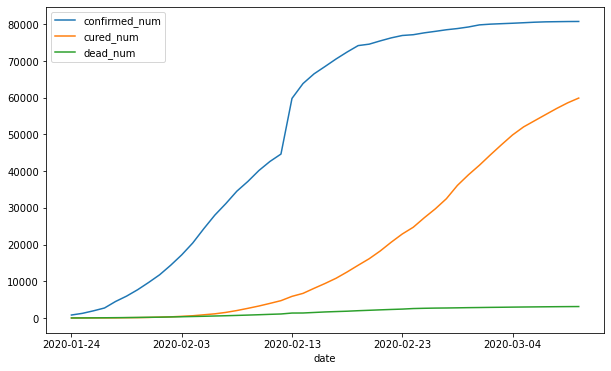

In [6]:
df = pd.read_csv("../../../data/covid-19.csv", sep='\t')
df.plot(x='date', y=['confirmed_num','cured_num','dead_num'] \
    ,figsize=(10,6))
plt.xticks()
df.head(10)

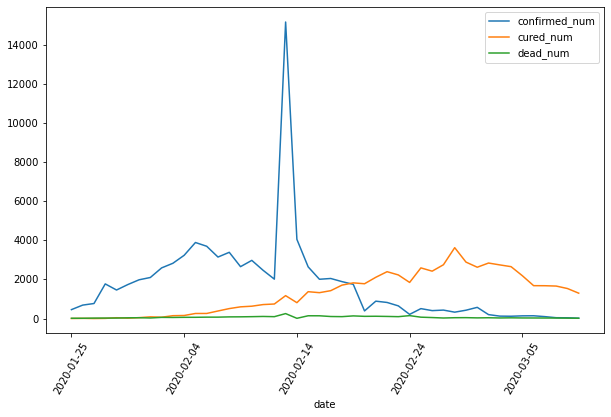

In [10]:
dfdata = df.set_index('date') #改变index为date
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index('date')

dfdiff.plot(x='date', y=['confirmed_num', 'cured_num', 'dead_num'] \
    ,figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop('date', axis=1).astype('float32')

In [12]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

## 二，定义模型

In [13]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config


In [14]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

## 三，训练模型

In [15]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config


In [16]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

500
1/1 [==============================] - 0s 65ms/step - loss: 0.2647
Epoch 255/500
1/1 [==============================] - 0s 91ms/step - loss: 0.2646
Epoch 256/500
1/1 [==============================] - 0s 72ms/step - loss: 0.2645
Epoch 257/500
1/1 [==============================] - 0s 66ms/step - loss: 0.2644
Epoch 258/500
1/1 [==============================] - 0s 65ms/step - loss: 0.2643
Epoch 259/500
1/1 [==============================] - 0s 66ms/step - loss: 0.2642
Epoch 260/500
1/1 [==============================] - 0s 66ms/step - loss: 0.2641
Epoch 261/500
1/1 [==============================] - 0s 67ms/step - loss: 0.2640
Epoch 262/500
1/1 [==============================] - 0s 65ms/step - loss: 0.2641
Epoch 263/500
1/1 [==============================] - 0s 66ms/step - loss: 0.2643
Epoch 264/500
1/1 [==============================] - 0s 66ms/step - loss: 0.2644
Epoch 265/500
1/1 [==============================] - 0s 66ms/step - loss: 0.2637
Epoch 266/500
1/1 [===================

## 四，评估模型

In [17]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

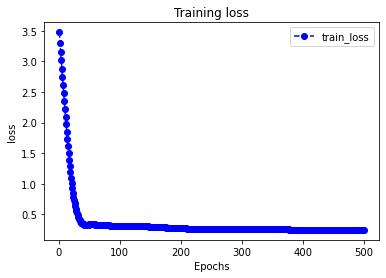

In [18]:
plot_metric(history,"loss")

## 五，使用模型

In [19]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [20]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [21]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
58,0.0,280.0,37.0
59,0.0,247.0,36.0
60,0.0,214.0,40.0
61,0.0,191.0,47.0
62,0.0,171.0,49.0


In [22]:
dfresult.query("cured_num==0").head()

# 第164天开始新增治愈降为0，第45天对应3月10日，也就是大概4个月后，即7月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数

,confirmed_num,cured_num,dead_num
99,0.0,0.0,0.0
100,0.0,0.0,0.0
101,0.0,0.0,0.0
102,0.0,0.0,0.0
103,0.0,0.0,0.0


In [23]:
dfresult.query("dead_num==0").head()

# 第60天开始，新增死亡降为0，第45天对应3月10日，也就是大概15天后，即20200325
# 该预测较为合理

,confirmed_num,cured_num,dead_num
88,0.0,6.0,0.0
89,0.0,5.0,0.0
90,0.0,4.0,0.0
91,0.0,4.0,0.0
92,0.0,4.0,0.0


## 六，保存模型

In [25]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel\assets
export saved model.


array([[1.01563104e+03, 9.31025696e+01, 2.76919127e+00],
       [1.25272449e+03, 7.30008774e+01, 5.63068867e+00],
       [1.36691650e+03, 1.55523605e+02, 5.26146317e+00],
       [1.56433313e+03, 1.66103455e+02, 5.90760803e+00],
       [1.88029651e+03, 2.75075775e+02, 5.99991417e+00],
       [1.78739453e+03, 2.76133759e+02, 6.73836517e+00],
       [1.52078528e+03, 4.09439728e+02, 6.73836517e+00],
       [1.63788049e+03, 5.39571716e+02, 7.93834829e+00],
       [1.28320801e+03, 6.33732300e+02, 8.21526718e+00],
       [1.43852844e+03, 6.68645752e+02, 8.95371819e+00],
       [1.19369312e+03, 7.56458374e+02, 9.96908855e+00],
       [9.74986450e+02, 7.87139893e+02, 8.95371819e+00],
       [7.33102734e+03, 1.23889893e+03, 2.34458199e+01],
       [1.95819861e+03, 8.59082825e+02, 1.19998288e+00],
       [1.27788550e+03, 1.45261169e+03, 1.31998119e+01],
       [9.71599426e+02, 1.39971252e+03, 1.31075058e+01],
       [9.90953979e+02, 1.50762683e+03, 9.69216919e+00],
       [9.13535706e+02, 1.80703